# Circuit example from Homework 3

In [34]:
import time
import datetime
import math
import numpy as np
import sympy as sp
%matplotlib notebook
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.arithmetic import *
from qiskit import BasicAer # for simulating circuits
from qiskit.tools.visualization import plot_histogram
from qiskit import execute

from qiskit.utils import QuantumInstance
from qiskit.algorithms import Shor

In [2]:
q = QuantumRegister(1, 'q') # specify the number of qubits in the register and a name

circ = QuantumCircuit(q)

In [3]:
# Set up circuit
q = QuantumRegister(3, 'cat3')
circ = QuantumCircuit(q)

# Add gates
circ.h(q[0])
circ.cx(q[0], q[1])
circ.cx(q[0], q[2])

circ.draw()

┌───┐          
cat3_0: ┤ H ├──■────■──
        └───┘┌─┴─┐  │  
cat3_1: ─────┤ X ├──┼──
             └───┘┌─┴─┐
cat3_2: ──────────┤ X ├
                  └───┘

In [4]:
backend = BasicAer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
catstate = result.get_statevector(circ)
print('Statevector:', catstate)
print()
print('Probabilities:', np.abs(catstate)**2)

Statevector: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]

Probabilities: [0.5 0.  0.  0.  0.  0.  0.  0.5]


In [5]:
c = ClassicalRegister(3, 'c')
circ.add_register(c)
circ.measure(q[0],c[0])
circ.measure(q[1],c[1])
circ.measure(q[2],c[2])

backend = BasicAer.get_backend('qasm_simulator')
job = execute(circ, backend, shots=1000)
result = job.result()

counts = result.get_counts()
print(counts)
#plot_histogram(counts)

{'000': 535, '111': 465}


# Multiplier 

In [12]:
# Initialize circuit
SIZE = 4 # Number of Qubits for multiply inputs

a = QuantumRegister(SIZE, 'a')
b = QuantumRegister(SIZE, 'b')
c = QuantumRegister(2*SIZE, 'c')
aux = QuantumRegister(1, 'aux')
circ = QuantumCircuit(a, b, c, aux)

# Set some input state
# a = 3
circ.x(a[0:1+1])
# b = superposition of 2 and 3
circ.h(b[0])
circ.x(b[1])

# Add the multiplier
mult = HRSCumulativeMultiplier(SIZE, name='mult')
circ.append(mult, a[:]+b[:]+c[:]+aux[:])

# Add output measurements
outReg = ClassicalRegister(2*SIZE, 'output')
circ.add_register(outReg)
circ.measure(c, outReg)

circ.draw()

┌───┐┌────────┐                        
     a_0: ┤ X ├┤0       ├────────────────────────
          ├───┤│        │                        
     a_1: ┤ X ├┤1       ├────────────────────────
          └───┘│        │                        
     a_2: ─────┤2       ├────────────────────────
               │        │                        
     a_3: ─────┤3       ├────────────────────────
          ┌───┐│        │                        
     b_0: ┤ H ├┤4       ├────────────────────────
          ├───┤│        │                        
     b_1: ┤ X ├┤5       ├────────────────────────
          └───┘│        │                        
     b_2: ─────┤6       ├────────────────────────
               │        │                        
     b_3: ─────┤7       ├────────────────────────
               │        │┌─┐                     
     c_0: ─────┤8  mult ├┤M├─────────────────────
               │        │└╥┘┌─┐                  
     c_1: ─────┤9       ├─╫─┤M├──────────────────
               │        │ ║ └╥┘┌─┐               
     c_2: ─────┤10      ├─╫──╫─┤M├───────────────
               │        │ ║  ║ └╥┘┌─┐            
     c_3: ─────┤11      ├─╫──╫──╫─┤M├────────────
               │        │ ║  ║  ║ └╥┘┌─┐         
     c_4: ─────┤12      ├─╫──╫──╫──╫─┤M├─────────
               │        │ ║  ║  ║  ║ └╥┘┌─┐      
     c_5: ─────┤13      ├─╫──╫──╫──╫──╫─┤M├──────
               │        │ ║  ║  ║  ║  ║ └╥┘┌─┐   
     c_6: ─────┤14      ├─╫──╫──╫──╫──╫──╫─┤M├───
               │        │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
     c_7: ─────┤15      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
               │        │ ║  ║  ║  ║  ║  ║  ║ └╥┘
     aux: ─────┤16      ├─╫──╫──╫──╫──╫──╫──╫──╫─
               └────────┘ ║  ║  ║  ║  ║  ║  ║  ║ 
output: 8/════════════════╩══╩══╩══╩══╩══╩══╩══╩═
                          0  1  2  3  4  5  6  7

## QASM Simulation

Counts = {'00001001': 535, '00000110': 489}


<IPython.core.display.Javascript object>


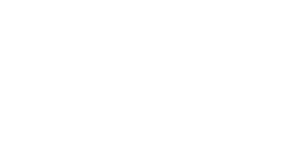

<IPython.core.display.Javascript object>


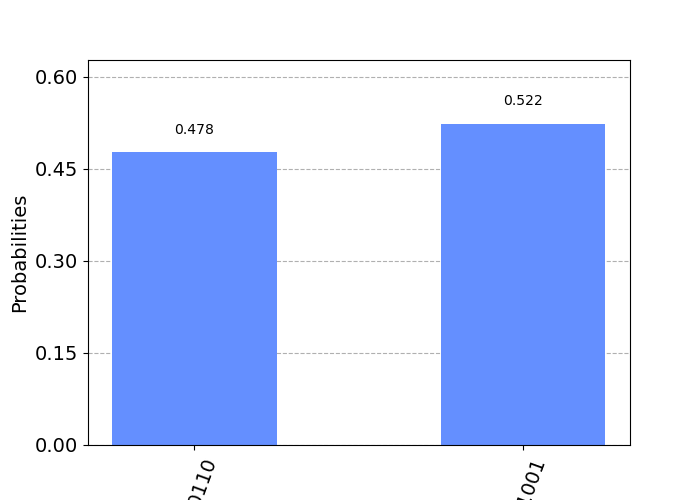

In [13]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(circ, backend, shots=1024)
result = job.result()

counts = result.get_counts()
print('Counts = {c}'.format(c=counts))
plot_histogram(counts)

# Provided Shor

In [28]:
start_time = time.time()

N = 21
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
shor = Shor(quantum_instance=quantum_instance)
result = shor.factor(N)

elapsed_time = time.time() - start_time
print("Elapsed time:", datetime.timedelta(seconds=elapsed_time))

Elapsed time: 1:03:51.984061


In [19]:
print("Actual number of qubits of circuit: ", shor.construct_circuit(21).num_qubits)

Actual number of qubits of circuit:  22


In [22]:
backend.available_devices()

AttributeError: 'QasmSimulatorPy' object has no attribute 'available_devices'

In [29]:
print("Factors of", N, ":", result.factors[0])

Factors of 21 : [3, 7]


# Classical Implementation of Shor's Algorithm

In [ ]:
def classical_shor(a, N):
    remainder = 0
    r = 1
    start_time = time.time()
    current_time = start_time
    while ((remainder == 0) or (remainder != 1)):
        remainder = (a**r) % N
        r += 1
        sub_elapsed_time = time.time() - current_time
        if (sub_elapsed_time > 300):
            total_elapsed_time = time.time() - start_time
            print("r=", r, "elapsed time:", datetime.timedelta(seconds=total_elapsed_time))
            current_time = time.time()


    r -= 1

    #print("a=", a, "r=", r, "remainder=", remainder)

    if (r % 2 == 0):
        x = a**(int(r/2)) % N
        if ((x + 1) != (0 % N)):
            x = int(x)
            print("gcd(x+1,N):", math.gcd(x+1,N))
            print("gcd(x-1,N):", math.gcd(x-1,N))
            print("r=", r)
        else:
            print("Try another a")
    else:
        print("Try another a")
        

In [98]:
def my_randprime(n):
    return sp.randprime(2,2**n)

In [99]:
#n = 4 # number of bits of prime factors

for n in range(4,20):
    prime_1 = my_randprime(n)
    prime_2 = my_randprime(n)
    N = prime_1 * prime_2
    a = my_randprime(n)
    while (math.gcd(a, N) != 1):
        a = my_randprime(n)
    
    print("n=", n)
    print("N=", N)
    
    start = time.time()
    classical_shor(a, N)
    elapsed_time = time.time() - start

    print("Elapsed time:", datetime.timedelta(seconds=elapsed_time))
    print("---------")

n= 4
N= 143
Try another a
Elapsed time: 0:00:00
---------
n= 5
N= 377
gcd(x+1,N): 377
gcd(x-1,N): 1
Elapsed time: 0:00:00
---------
n= 6
N= 3233
Try another a
Elapsed time: 0:00:00
---------
n= 7
N= 2407
gcd(x+1,N): 2407
gcd(x-1,N): 1
Elapsed time: 0:00:00.001994
---------
n= 8
N= 11659
gcd(x+1,N): 89
gcd(x-1,N): 131
Elapsed time: 0:00:00.008979
---------
n= 9
N= 20303
gcd(x+1,N): 257
gcd(x-1,N): 79
Elapsed time: 0:00:01.274633
---------
n= 10
N= 277507
r= 58763 elapsed time: 0:05:00.000620
r= 74970 elapsed time: 0:10:00.009402
r= 88135 elapsed time: 0:15:00.014146
r= 98734 elapsed time: 0:20:00.016027
r= 108597 elapsed time: 0:25:00.025562
r= 116893 elapsed time: 0:30:00.027083
r= 124355 elapsed time: 0:35:00.056628
r= 131264 elapsed time: 0:40:00.090024
r= 137679 elapsed time: 0:45:00.109174
gcd(x+1,N): 773
gcd(x-1,N): 359
Elapsed time: 0:45:27.234507
---------
n= 11
N= 809089
r= 66111 elapsed time: 0:05:00.007833
r= 86668 elapsed time: 0:10:00.018996
r= 100978 elapsed time: 0:15:00.

KeyboardInterrupt: 